# Benchmark workshop live session

## Learning objectives
<br>

By the end of this workshop you will be able to:
 1. Identify torsion violations 
 2. Identify forcefield parameters associated with torsion violations
 3. Visualize violation frequency as a function of torsion parameter

In [1]:
from rdkit.Chem import rdMolTransforms
from rdkit.Chem import PandasTools
from tqdm import tqdm
from glob import glob

import pandas as pd
import numpy as np
import os
import json

## 1. Identify torsion violations

This first part of the code section loads the sdf files of the QM and MM methods, then goes through all the torsions
to compare the QM and MM values and outputs the conformers that exhibit a torsion deviation larger than a given threshold.
Since a given torsion is defined by 4 atoms indices, but the bond which is rotating is always defined by the 2 middle indices, a single rotatable bond may be identified as an outlier multiple times since it is central to multiple torsions. 
The last part of this code section removes such duplicates.

In [2]:
qm_glob = 'data/b3lyp-d3bj/dzvp/*.sdf'
mm_glob = 'data/openff-1.3.0/*.sdf'

qm_data = []
for sdf in glob(qm_glob):
    df = PandasTools.LoadSDF(sdf)
    qm_data.append(df)

qm_data = pd.concat(qm_data)
qm_data = qm_data[['conformer_index', 'molecule_index', 'final_energy', 'ID', 'ROMol']]
qm_data.columns = ['confID', 'MolID', 'Eqm', 'ID', 'mol_qm']

mm_data = []
for sdf in glob(mm_glob):
    df = PandasTools.LoadSDF(sdf)
    mm_data.append(df)
    
mm_data = pd.concat(mm_data)
mm_data = mm_data[['ID', 'ROMol']]
mm_data.columns = ['ID', 'mol_off']

df = pd.merge(qm_data, mm_data, on='ID')

df['Eqm_kcal_per_mol'] = df['Eqm'].str.replace('kilocalorie / mole', '')
df = df.astype({'Eqm_kcal_per_mol': float})

df.sort_values(by=['MolID', 'Eqm_kcal_per_mol'], inplace=True)

df = df.groupby(['MolID']).first()

In [3]:
t_violations = list()
threshold_degrees = 30.
for i, row in df.iterrows():
    mol1, mol2 = row[['mol_qm','mol_off']]

    name = mol1.GetProp("_Name")
    
    conf1 = mol1.GetConformer()
    conf2 = mol2.GetConformer()
    
    # Search for all dihedrals i-j-k-l by iterating over all possible j-k bonds
    for bond in mol1.GetBonds():
        atom_j = bond.GetBeginAtom()
        atom_k = bond.GetEndAtom()
        
        # Iterate over bonded neighbors of j that are not k
        for atom_i in atom_j.GetNeighbors():
            if atom_i == atom_k:
                continue
            # Iterate over bonded neighbors of k that are not j
            for atom_l in atom_k.GetNeighbors():
                if (atom_l == atom_j):
                    continue
                
                # Compare the measured angle of the dihedral in the QM and MM structures
                t1 = round(rdMolTransforms.GetDihedralDeg(conf1, 
                                                          atom_i.GetIdx(), 
                                                          atom_j.GetIdx(),
                                                          atom_k.GetIdx(),
                                                          atom_l.GetIdx(),
                                                          ), 2)
                t2 = round(rdMolTransforms.GetDihedralDeg(conf2, 
                                                          atom_i.GetIdx(), 
                                                          atom_j.GetIdx(),
                                                          atom_k.GetIdx(),
                                                          atom_l.GetIdx(),
                                                          ), 2)
                # Test whether the difference in angles between the QM and MM structures
                # exceeds the threshold, and record the violation if so
                diff = round(abs(t1-t2), 2)
                if diff > 180:
                    diff = abs(diff - 360)

                if diff > threshold_degrees:

                    t_violations.append([name, 
                                         atom_i.GetSymbol(), 
                                         atom_j.GetSymbol(), 
                                         atom_k.GetSymbol(), 
                                         atom_l.GetSymbol(), 
                                         atom_i.GetIdx()+1,
                                         atom_j.GetIdx()+1,
                                         atom_k.GetIdx()+1,
                                         atom_l.GetIdx()+1,
                                         t1, 
                                         t2, 
                                         diff])

# convert violation lists into a common dataframe

t_violations = pd.DataFrame(t_violations)
column_ids = ['ID', 'at1', 'at2', 'at3', 'at4', 'i', 'j', 'k', 'l', 'val_qm', 'val_off', 'difference']
if len(t_violations.index) != 0:
    t_violations.columns = column_ids

dfout = pd.DataFrame(t_violations)

dfout = dfout[column_ids]

In [4]:
print(dfout.to_string())

               ID at1 at2 at3 at4   i   j   k   l  val_qm  val_off  difference
0    JNS-00129-06   N   C   C   F  14  15  18  19  179.82  -121.67       58.51
1    JNS-00129-06   N   C   C   F  14  15  18  20   59.86   119.98       60.12
2    JNS-00129-06   N   C   C   F  14  15  18  21  -60.21    -0.93       59.28
3    JNS-00129-06   C   C   C   F  16  15  18  19    0.34    58.20       57.86
4    JNS-00129-06   C   C   C   F  16  15  18  20 -119.63   -60.16       59.47
5    JNS-00129-06   C   C   C   F  16  15  18  21  120.30   178.94       58.64
6    XTP-00455-03   C   C   C   F   2  12  14  15 -118.17   -59.29       58.88
7    XTP-00455-03   C   C   C   F   2  12  14  16  121.60   179.91       58.31
8    XTP-00455-03   C   C   C   F   2  12  14  17    1.61    59.16       57.55
9    XTP-00455-03   N   C   C   F  19  12  14  15   61.43   120.79       59.36
10   XTP-00455-03   N   C   C   F  19  12  14  16  -58.80    -0.01       58.79
11   XTP-00455-03   N   C   C   F  19  12  14  17 -1

### Filter dataset to only contain one representative of each rotatable bond with violations

In [5]:
violations = dfout.rename(columns={'ID': 'mm_conf'})
# Since we are just keeping one representative violation for each central bond, the specific
# angle and difference don't matter and could confuse us later, so we drop that info here.
violations.drop(['val_qm', 'val_off', 'difference'], inplace=True, axis=1)


#### Challenge
In the `violation` dataframe containing the i,j,k,l values in the corresponding columns, create a new column containing the (i, j, k, l) tuple in the 0-based indexing system.

#### Solution

In [6]:
violations['viol_indices'] = list(zip(violations.i-1, violations.j-1, violations.k-1, violations.l-1))

In [7]:
# Get rid of duplicate violations that share a central bond
unique_violations = violations.copy()
seen_central_bonds = set()

for i, row in violations.iterrows():
    central_bond_indices = tuple(sorted(row['viol_indices'][1:3]))
    central_bond_id = (row['mm_conf'], central_bond_indices)
    if central_bond_id in seen_central_bonds:
        unique_violations.drop(i, inplace=True)
        continue
    else:
        seen_central_bonds.add(central_bond_id)


In [8]:
unique_violations = unique_violations.sort_values(['mm_conf', 'viol_indices'])
print(unique_violations.to_string())

          mm_conf at1 at2 at3 at4   i   j   k   l      viol_indices
30   BRI-00638-05   C   C   O   C   1   2   3   4      (0, 1, 2, 3)
31   BRI-00638-05   C   C   N   S   4   5   6   7      (3, 4, 5, 6)
32   BRI-00638-05   C   C   C   F  19  20  22  23  (18, 19, 21, 22)
38   BRI-00647-05   N   C   C   O   8   9  21  22    (7, 8, 20, 21)
42   BRI-00647-05   N   C   C   F  13  14  17  18  (12, 13, 16, 17)
54   BRI-00739-00   C   C   C   C   3   5  11  10     (2, 4, 10, 9)
55   BRI-00739-00   C   C   C   F  14  15  19  20  (13, 14, 18, 19)
86   BRI-01231-06   C   O   C   C   1   2   3   4      (0, 1, 2, 3)
88   BRI-01231-06   N   C   C   F   8   9  12  13    (7, 8, 11, 12)
159  BRI-01456-04   N   C   C   F  15  16  20  21  (14, 15, 19, 20)
177  BRI-01545-01   O   C   C   N   5   6   8  13     (4, 5, 7, 12)
178  BRI-01545-01   C   C   C   F  16  17  20  21  (15, 16, 19, 20)
12   GNT-00519-00   C   C   C   F  10  14  20   3    (9, 13, 19, 2)
0    JNS-00129-06   N   C   C   F  14  15  18  1

### Challenge
In the `unique_violations` dataframe, select only the violations tuples that contain (i,2,5,l) as the rotating bond

In [9]:
# TO JEFF: Make this prettier/make a new dataframe
for i, row in unique_violations.iterrows():
    #if row['viol_indices'][1:3] == t[1:3]:
    if row['j'] == 2 and row['k'] == 5:
        print(row.to_string())

mm_conf         JNS-01242-05
at1                        F
at2                        C
at3                        C
at4                        C
i                          1
j                          2
k                          5
l                          6
viol_indices    (0, 1, 4, 5)
mm_conf         JNS-01558-03
at1                        F
at2                        C
at3                        C
at4                        N
i                          1
j                          2
k                          5
l                          6
viol_indices    (0, 1, 4, 5)
mm_conf         JNS-01581-08
at1                        F
at2                        C
at3                        C
at4                        N
i                          1
j                          2
k                          5
l                          6
viol_indices    (0, 1, 4, 5)
mm_conf         JNS-01586-05
at1                        F
at2                        C
at3                        C
at4           

## 2. Identify forcefield parameters associated with torsion violations

In order to identify which parameter corresponds to a given torsion violation, we build a dictionary containing
all the parameters exercised by the conformers that are producing a violation. Afterwards, we search the middle
indices of the violating torsions that match the middle indices of the torsion parameters.

In [10]:
from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import ForceField

/Users/jeffreywagner/miniconda3/envs/2021-benchmarking-workshop/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Importing this package as `import openforcefield.XXX` and `from openforcefield import XXX` was marked for deprecation in version `0.8.3`. From version `0.9.0` onwards this package will need to be imported as `import openff.toolkit.XXX` and `from openff.toolkit import XXX`. See the `0.8.3` release notes for more information. A migration guide is also available at https://github.com/openforcefield/openff-toolkit/issues/819
  """Entry point for launching an IPython kernel.


In [11]:
path_input = 'data/openff-1.3.0/'
mols = []

# Load one conformer of each molecule with a violation
for mol in unique_violations.mm_conf:
    mols.append(mol)
mols = np.unique(mols).tolist()

# Load the molecules into a pandas dataframe with columns of [conformer name, OpenFF Molecule]
ff_mols = dict()
for mol_name in mols:
    ff_mols[mol_name] = Molecule.from_file(f'{path_input}/{mol_name}.sdf', 'SDF')

mm_df = pd.DataFrame(ff_mols.items(), columns=['mm_conf', 'molecule'])

# Load Parsley 1.3.0 and use it to label the parameters assigned to the molecules
forcefield = ForceField('openff-1.3.0.offxml')
mm_parm = mm_df.copy()
for i, row in tqdm(mm_df.iterrows(), total=mm_df.shape[0], desc='Creating ff parm dict'):
    molecule = row['molecule']
    topology = Topology.from_molecules([molecule])
    # Store the parameter assignment dict in the pandas dataframe for each molecule
    mm_parm.loc[i, 'ff_parm'] = forcefield.label_molecules(topology)

mm_parm.set_index('mm_conf', inplace=True)

Creating ff parm dict: 100%|████████████████████| 50/50 [01:09<00:00,  1.39s/it]


In [12]:
results = {}
for i, row in unique_violations.iterrows():
    mm_conf = row['mm_conf']
    mol_forces = mm_parm.loc[mm_conf]['ff_parm']
    force_dict = mol_forces['ProperTorsions']
    viol_central_atoms = sorted(row['viol_indices'][1:3])
    c = 0
    for atom_indices, parameter in force_dict.items():
        assigned_torsion_central_atoms = sorted(atom_indices[1:3])
        if viol_central_atoms == assigned_torsion_central_atoms:
            result_id = f'{mm_conf}_{c}'
            c += 1
            results[result_id] = {
                'mm_conf': mm_conf,
                'parameter': parameter.id,
                'viol_ids': row['viol_indices'],
                'parm_ids': atom_indices,
                'smirks': parameter.smirks
                }

In [13]:
results_df = pd.DataFrame.from_dict(results, orient='index')
print(results_df.to_string())

                     mm_conf parameter          viol_ids          parm_ids                                           smirks
BRI-00638-05_0  BRI-00638-05       t17  (18, 19, 21, 22)  (18, 19, 21, 22)                    [*:1]~[#6X3:2]-[#6X4:3]-[*:4]
BRI-00638-05_1  BRI-00638-05       t17  (18, 19, 21, 22)  (18, 19, 21, 23)                    [*:1]~[#6X3:2]-[#6X4:3]-[*:4]
BRI-00638-05_2  BRI-00638-05       t17  (18, 19, 21, 22)  (18, 19, 21, 24)                    [*:1]~[#6X3:2]-[#6X4:3]-[*:4]
BRI-00638-05_3  BRI-00638-05       t17  (18, 19, 21, 22)  (20, 19, 21, 22)                    [*:1]~[#6X3:2]-[#6X4:3]-[*:4]
BRI-00638-05_4  BRI-00638-05       t17  (18, 19, 21, 22)  (20, 19, 21, 23)                    [*:1]~[#6X3:2]-[#6X4:3]-[*:4]
BRI-00638-05_5  BRI-00638-05       t17  (18, 19, 21, 22)  (20, 19, 21, 24)                    [*:1]~[#6X3:2]-[#6X4:3]-[*:4]
BRI-00647-05_0  BRI-00647-05       t17  (12, 13, 16, 17)  (12, 13, 16, 17)                    [*:1]~[#6X3:2]-[#6X4:3]-[*:4]
BRI-0064

## 3. Visualize violation frequency as a function of torsion parameter

We want to visualize how many time a torsion parameter has produced a violation and to normalize it by the number of times the parameter has been exercised

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

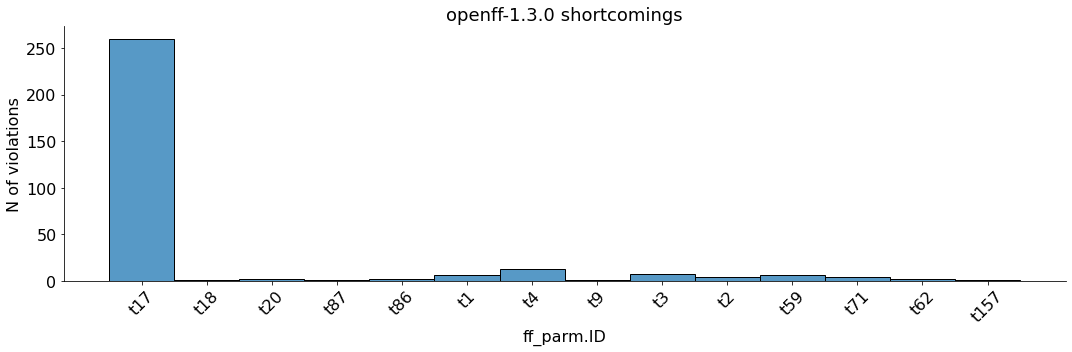

In [15]:
sns.displot(results_df, x = 'parameter', height = 5, aspect = 3)

plt.title('openff-1.3.0 shortcomings', fontsize=18)
plt.xlabel('ff_parm.ID', fontsize=16)
plt.ylabel('N of violations', fontsize=16)
plt.xticks(fontsize=16, rotation=45)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()

### Wow, `t17` sure looks bad. 

But are we sure it's not just because `t17` is a generic parameter that's just assigned a lot in general? Let's normalize the violation count by the number of times that `t17` is assigned.

In [16]:
# open the coverage report and select torsion parameter exercised in the dataset
with open('data/coverage-report/coverage_report.json', 'r') as f:
    cov = json.load(f)
tor_parms = pd.Series(cov['ProperTorsions'])
tor_parms = tor_parms.reset_index()
tor_parms.columns = ['parameter', 'parm_count']
tor_parms = tor_parms.sort_values(['parm_count', 'parameter'])

# counts number of violations produced by a parameter
counts = results_df['parameter'].value_counts()
counts_df = pd.Series.to_frame(counts)
counts_df.reset_index(level=0, inplace=True)
counts_df = counts_df.rename(columns={'index': 'parameter', 'parameter': 'viol_count'})
counts_df = pd.merge(counts_df, tor_parms, on='parameter', how='inner')
counts_df['rel_viol'] = counts_df['viol_count'] / counts_df['parm_count'] * 100

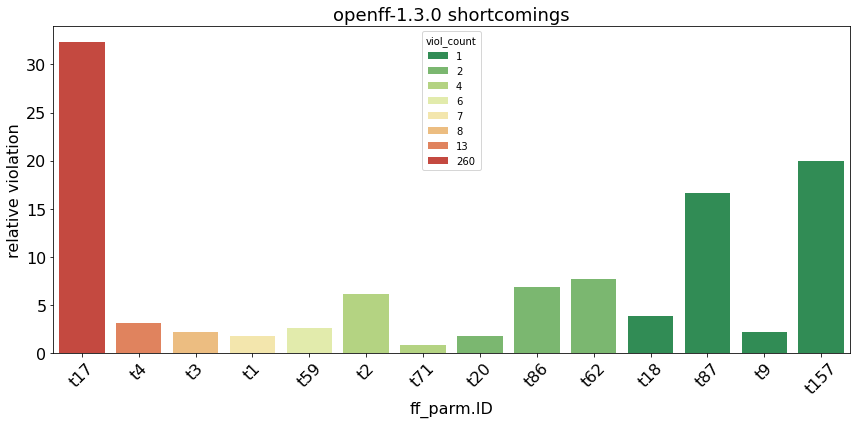

In [17]:
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x='parameter',
            y='rel_viol',
            ax=ax,
            data=counts_df,
            hue='viol_count',
            palette='RdYlGn_r',
            dodge=False)

plt.title('openff-1.3.0 shortcomings', fontsize=18)
plt.xlabel('ff_parm.ID', fontsize=16)
plt.ylabel('relative violation', fontsize=16)
plt.xticks(fontsize=16, rotation=45)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()